In [1921]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [1922]:
# Load the dataset
df = pd.read_csv('/kaggle/input/weather-dataset/weather_data.csv')

In [1923]:
# Extract the temperature column
temp = df['temperature']

In [1924]:
# Normalize the temperature data
scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaled = scaler.fit_transform(temp.values.reshape(-1, 1))

In [1925]:
# Function to convert the dataframe into X and y for training
def df_to_X_y(df, window_size= 19):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [1926]:
# Set the window size
WINDOW_SIZE = 19

In [1927]:
# Prepare the data using the normalized temperature values
X, y = df_to_X_y(pd.DataFrame(temp_scaled), WINDOW_SIZE)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (889, 19, 1, 1)
y shape: (889, 1)


In [1928]:
# Split the data into training, validation, and test sets
X_train, y_train = X[:622], y[:622]
X_val, y_val = X[622:755], y[622:755]
X_test, y_test = X[755:], y[755:]

In [1929]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (622, 19, 1, 1) (622, 1)
Validation set shape: (133, 19, 1, 1) (133, 1)
Test set shape: (134, 19, 1, 1) (134, 1)


In [1930]:
# Model Definition (you can adjust layers and neurons as needed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional, InputLayer, LeakyReLU, BatchNormalization


In [1931]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE, 1)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128))
model.add(Dense(128))
model.add(LeakyReLU(negative_slope=0.001)) 
model.add(Dense(1, activation='linear'))

In [1932]:
model.summary()

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_113               │ (None, 19, 128)        │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_114               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,761 (647.50 KB)

 Trainable params: 165,761 (647.50 KB)

 Non-trainable params: 0 (0.00 B)

In [1933]:
cp = ModelCheckpoint('model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.007), metrics=[RootMeanSquaredError()])

In [1934]:
# Train the model
history= model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp])


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.1945 - root_mean_squared_error: 0.4335 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1422
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0122 - root_mean_squared_error: 0.1100 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 6.7316e-04 - val_root_mean_squared_error: 0.0259
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054 - root_mean_squared_error: 0.0731 - val_loss: 6.2644e-04 - val_root_mean_squared_error: 0.0250
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 8.1078e-04 - val_root_mean_squared_error: 0.0285
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 4.7588e-04 - val_root_mean_squared_error: 0.0218
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [1935]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('model.keras')

In [1936]:
# Make predictions on the training data
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train.flatten()})

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


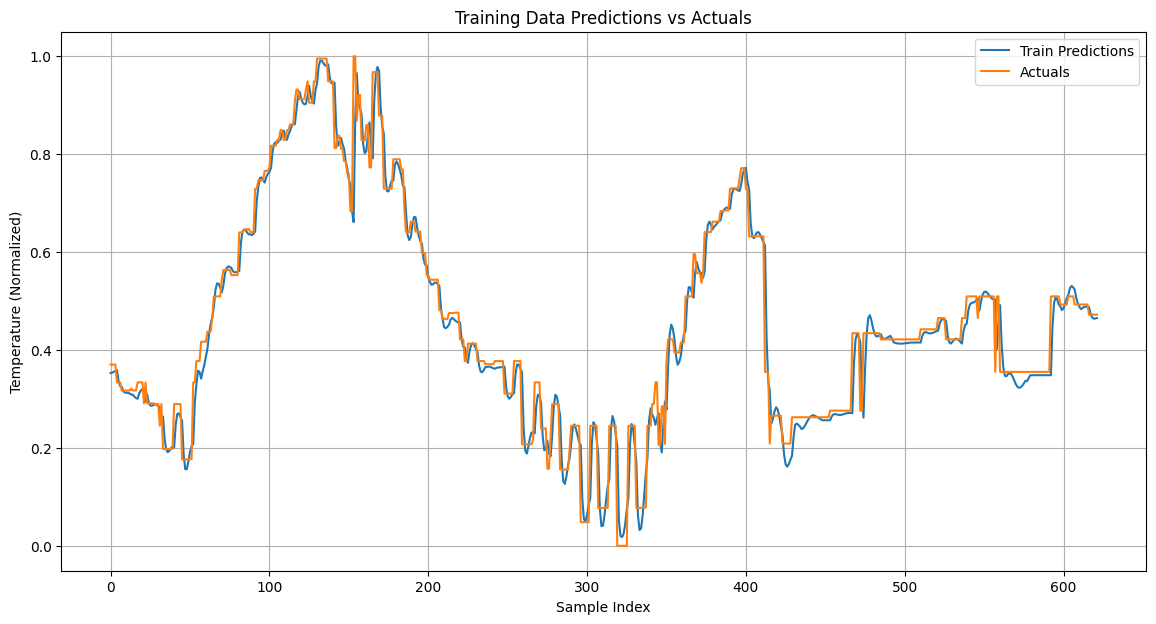

In [1937]:
# Plot the training predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(train_results['Train Predictions'][:], label='Train Predictions')
plt.plot(train_results['Actuals'][:], label='Actuals')
plt.title('Training Data Predictions vs Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.grid(True)
plt.savefig('training_predictions_vs_actuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [1938]:
# Make predictions on the test data
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test.flatten()})

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


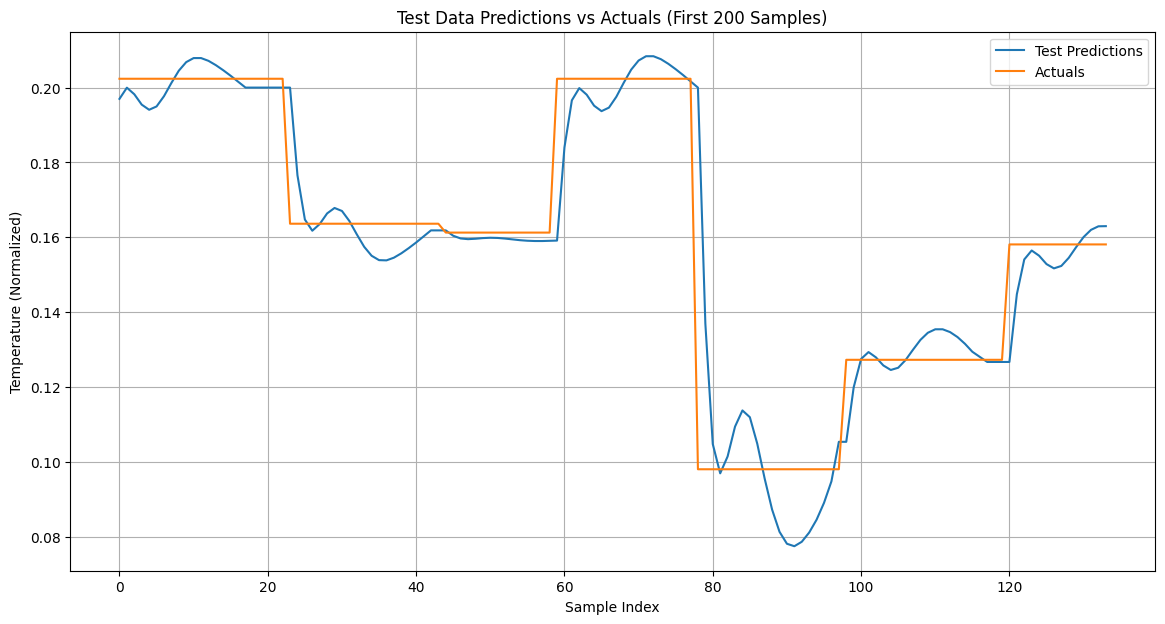

In [1939]:
# Plot the test predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(test_results['Test Predictions'][:200], label='Test Predictions')
plt.plot(test_results['Actuals'][:200], label='Actuals')
plt.title('Test Data Predictions vs Actuals (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.grid(True)
plt.savefig('test_predictions_vs_actuals.png', dpi=300, bbox_inches='tight')
plt.show()


In [1940]:
# Calculate and print R^2 Score and Mean Squared Error
r2 = r2_score(y_test, test_predictions)
print("R^2 Score:", r2)


R^2 Score: 0.8738032985901345


In [1941]:

mse = mean_squared_error(y_test, test_predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00016579733451507569


In [1942]:
# Optionally: Reverse the normalization for easier interpretation of the results
test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

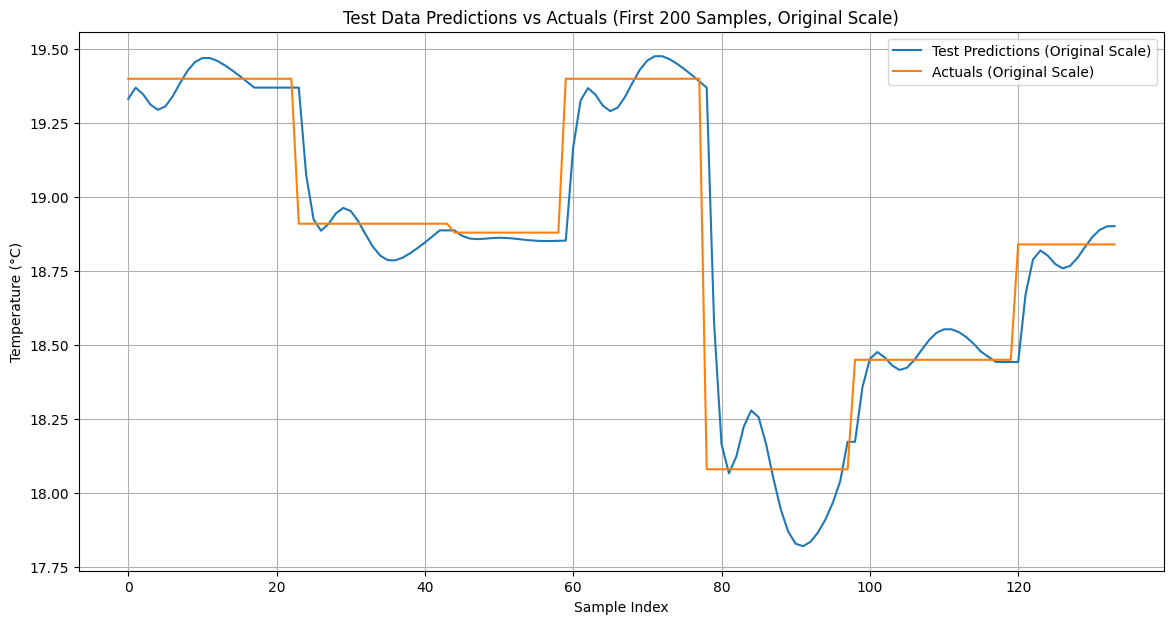

In [1943]:
# Plot the original scale predictions vs actuals for better interpretation
plt.figure(figsize=(14, 7))
plt.plot(test_predictions_original[:200], label='Test Predictions (Original Scale)')
plt.plot(y_test_original[:200], label='Actuals (Original Scale)')
plt.title('Test Data Predictions vs Actuals (First 200 Samples, Original Scale)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.savefig('test_predictions_vs_actuals_original_scale.png', dpi=300, bbox_inches='tight')

plt.show()

In [1944]:
# Print the R^2 and MSE for the original scale predictions
r2_original = r2_score(y_test_original, test_predictions_original)
print("R^2 Score (Original Scale):", r2_original)

R^2 Score (Original Scale): 0.8738034860708027


In [1945]:
mse_original = mean_squared_error(y_test_original, test_predictions_original)
print("Mean Squared Error (Original Scale):", mse_original)

Mean Squared Error (Original Scale): 0.026531264546934514


In [1946]:
# Show predictions and actuals in a table (for test data)
test_results_table = pd.DataFrame({
    'Test Predictions (Normalized)': test_predictions,
    'Actuals (Normalized)': y_test.flatten(),
    'Test Predictions (Original Scale)': test_predictions_original,
    'Actuals (Original Scale)': y_test_original
})

# Optionally save the table to a CSV file
test_results_table.to_csv('test_results_comparison.csv', index=False)

# You can also display it directly in Jupyter Notebook using pandas
from IPython.display import display
display(test_results_table.head(20))  # Display the first 20 rows for a quick preview


,Test Predictions (Normalized),Actuals (Normalized),Test Predictions (Original Scale),Actuals (Original Scale)
0,0.196998,0.202372,19.332024,19.4
1,0.199988,0.202372,19.369854,19.4
2,0.198229,0.202372,19.347595,19.4
3,0.195455,0.202372,19.312510,19.4
4,0.194084,0.202372,19.295162,19.4
5,0.194969,0.202372,19.306362,19.4
6,0.197704,0.202372,19.340950,19.4
7,0.201246,0.202372,19.385757,19.4
8,0.204523,0.202372,19.427219,19.4
9,0.206819,0.202372,19.456266,19.4


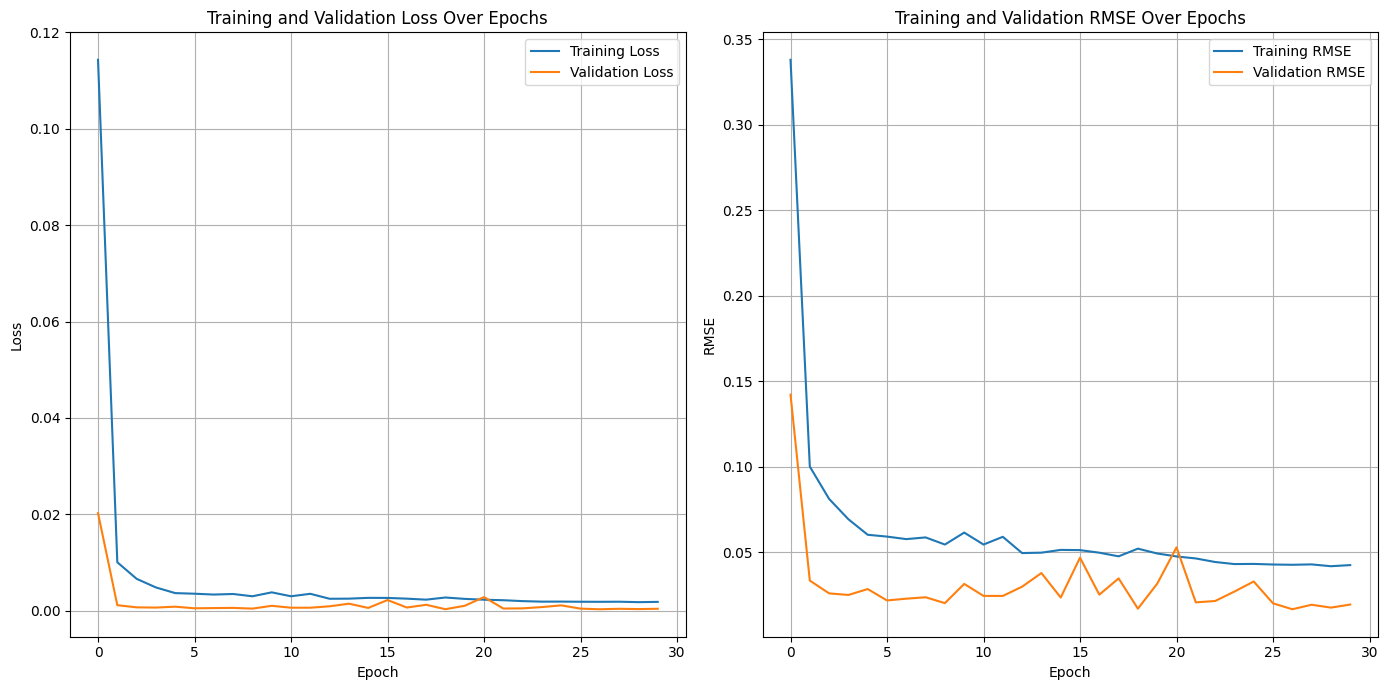

In [1947]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()

# Plot training & validation loss values
plt.figure(figsize=(14, 7))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_and_validation_loss_over_epochs.png', dpi=300, bbox_inches='tight')


# RMSE grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.savefig('training_and_validation_rmse_over_epochs.png', dpi=300, bbox_inches='tight')

# Show both subplots
plt.tight_layout()
plt.show()
